In [ ]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Load filtered complaints (simulate filtered_df)
df = pd.read_csv("data/bangkok_traffy_cleaned.csv")
df = df[df['type'].str.contains("ถนน", na=False)]
# df = df[0:100]


/tmp/ipykernel_62042/3599932280.py:8: DtypeWarning: Columns (4,13,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/bangkok_traffy_cleaned.csv")


: 

In [ ]:
# 2. Convert coords to lat/lon
df[['lon', 'lat']] = df['coords'].str.split(",", expand=True).astype(float)

# Optional: filter only coordinates within Bangkok bounds
df = df[(df['lat'].between(13.5, 14.2)) & (df['lon'].between(100.3, 100.9))]

# 3. Turn into GeoDataFrame
gdf_points = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326")

# 4. Get Bangkok road network (drivable)
G = ox.graph_from_place("Bangkok, Thailand", network_type="all")
edges = ox.graph_to_gdfs(G, nodes=False)

# Save before joining
edges_before = edges.copy()

# 5. Reproject to metric CRS for accurate distance
gdf_points_proj = gdf_points.to_crs(epsg=3857)
edges_proj = edges.to_crs(epsg=3857)

# 6. Spatial join (find nearest road to each complaint)
joined = gpd.sjoin_nearest(
    gdf_points_proj, 
    edges_proj[["geometry", "name"]], 
    how="left", 
    distance_col="dist_to_road",
    lsuffix="pt", rsuffix="road"
)

# 6.1 Filter by distance
max_dist = 100  # meters
before_filter = len(joined)
joined = joined[joined["dist_to_road"] <= max_dist]
after_filter = len(joined)

print(f"Filtered out {before_filter - after_filter} of {before_filter} complaints (>{max_dist}m from road)")


# 7. Fix list-type road names, then group and count
joined["name"] = joined["name"].apply(lambda x: x[0] if isinstance(x, list) else x)
road_counts = joined.groupby("name").size().reset_index(name="complaint_count")

# 8. Merge count back to road GeoDataFrame
edges["name"] = edges["name"].astype(str)
edges = edges.merge(road_counts, on="name", how="left").fillna(0)

# 9. Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
edges_before.plot(ax=axes[0], color="lightgrey", linewidth=0.5)
gdf_points.plot(ax=axes[0], color="red", markersize=5)
axes[0].set_title("Before: Complaints as Points")

edges.plot(ax=axes[1], column="complaint_count", cmap="hot", linewidth=1, legend=True)
axes[1].set_title("After: Complaints Aggregated to Roads")

for ax in axes:
    ax.set_axis_off()

plt.tight_layout()
plt.show()

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fcb9516b640>>
Traceback (most recent call last):
  File "/home/catsudon/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


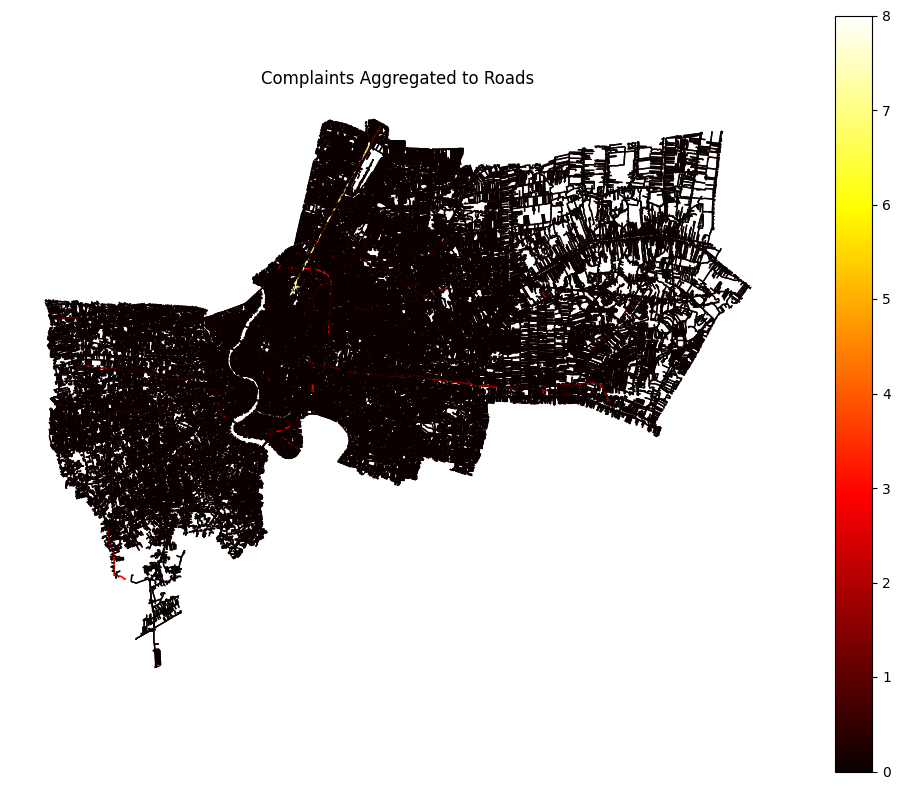

In [ ]:
# ✅ Plot only: Aggregated Complaints on Roads
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

edges.plot(
    ax=ax,
    column="complaint_count",
    cmap="hot",
    linewidth=1,
    legend=True
)

ax.set_title("Complaints Aggregated to Roads")
ax.set_axis_off()
plt.tight_layout()
plt.show()


/tmp/ipykernel_49901/3969475916.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', 10)


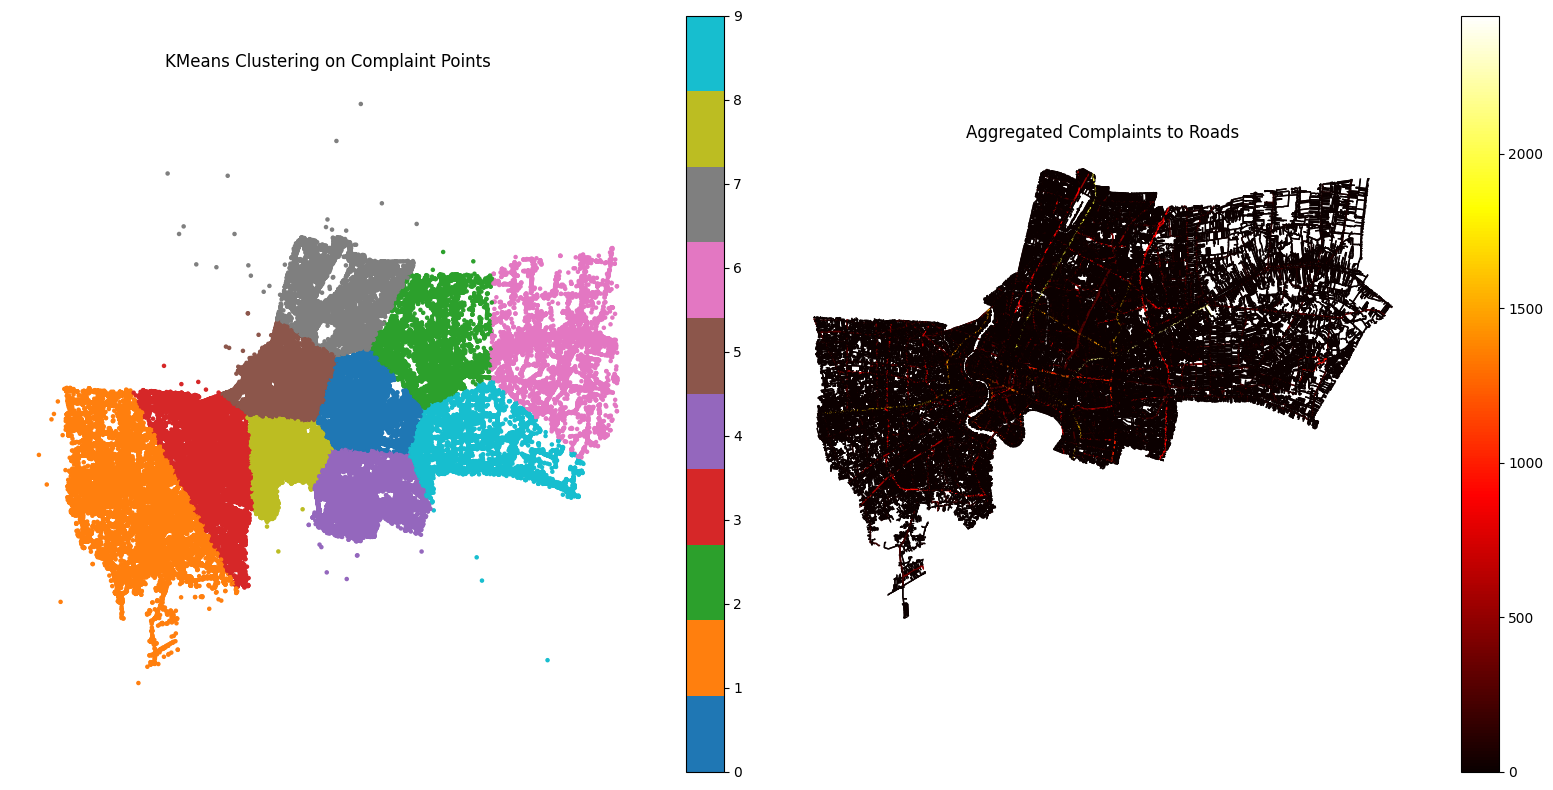

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

# --- Run KMeans on complaint points (projected)
coords = np.vstack([gdf_points_proj.geometry.x, gdf_points_proj.geometry.y]).T
kmeans = KMeans(n_clusters=10, random_state=42).fit(coords)
gdf_points_proj['kmeans_label'] = kmeans.labels_

# --- Color map per cluster
colors = plt.cm.get_cmap('tab10', 10)

# --- Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Before: just points with cluster colors
gdf_points_proj.plot(ax=axes[0], column="kmeans_label", cmap='tab10', markersize=5, legend=True)
axes[0].set_title("KMeans Clustering on Complaint Points")

# After: complaint count aggregated to roads
edges.plot(ax=axes[1], column="complaint_count", cmap="hot", linewidth=1, legend=True)
axes[1].set_title("Aggregated Complaints to Roads")

for ax in axes:
    ax.set_axis_off()

plt.tight_layout()
